In [3]:
import pandas as pd
import geopandas
import numpy
import json
from collections import defaultdict
import ast
import os

In [6]:
base_dir = "/media/gegen07/Expansion/data/mestrado/checkins_data"
basic_dir = os.path.join(base_dir, "basic_data")
general_dir = os.path.join(base_dir, "general")
checkins_with_category = os.path.join(base_dir, "checkins_local")

In [7]:
checkins = pd.read_csv(os.path.join(basic_dir, "gowalla_checkins.csv"))
places = pd.read_csv(os.path.join(basic_dir, "places.csv"))
with open(os.path.join(basic_dir, "gowalla_category.json")) as f:
    category = json.load(f)['spot_categories']

In [8]:
category

[{'name': 'Community',
  'image_url': 'http://static.gowalla.com/categories/934-c4bb6b0777a2de0f060c4d71b0db0ed8-100.png',
  'url': '/categories/934',
  'spot_categories': [{'name': 'Campus Spot',
    'image_url': 'http://static.gowalla.com/categories/133-6437b3f0e56f2414baa34781588befd1-100.png',
    'url': '/categories/133',
    'spot_categories': [{'name': 'Administration',
      'image_url': 'http://static.gowalla.com/categories/135-83777de928947312f311f05418a6a6f8-100.png',
      'url': '/categories/135',
      'description': '',
      'small_image_url': 'http://static.gowalla.com/categories/135-b8741a5f83c1189533cf2f0712e4d8e3-30.png'},
     {'name': 'Campus Commons',
      'image_url': 'http://static.gowalla.com/categories/138-2abf3dcbc010dbdba29f827a2264deec-100.png',
      'url': '/categories/138',
      'description': '',
      'small_image_url': 'http://static.gowalla.com/categories/138-36f6e10b93d0edcf483113a95a82f10b-30.png'},
     {'name': 'Campus - Other',
      'image_u

In [9]:
map_to_general_category = {}
category_names = []

In [22]:
def map_categories(data, category_map, name):
    for category in data:
        subcategory = category['name']
        category_map[subcategory] = name
        if 'spot_categories' in category:
            map_categories(category['spot_categories'], category_map, name)    

df_names = pd.DataFrame(columns=['name', 'categoryid'])

for i in range(len(category)):
    name = category[i]['name']
    df_names = df_names.append({'name': name, 'categoryid': i}, ignore_index=True)
    map_categories(category[i]['spot_categories'], map_to_general_category, name)

df_names.to_csv(os.path.join(general_dir, 'category_names.csv'), index=False)


/tmp/ipykernel_521184/3139987457.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_names = df_names.append({'name': name, 'categoryid': i}, ignore_index=True)
/tmp/ipykernel_521184/3139987457.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_names = df_names.append({'name': name, 'categoryid': i}, ignore_index=True)
/tmp/ipykernel_521184/3139987457.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_names = df_names.append({'name': name, 'categoryid': i}, ignore_index=True)
/tmp/ipykernel_521184/3139987457.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_names = df_names.append({'name': name, 'categoryid': i}, ign

In [20]:
set(map_to_general_category.values())

{'Community',
 'Entertainment',
 'Food',
 'Nightlife',
 'Outdoors',
 'Shopping',
 'Travel'}

In [23]:
def get_general_category(row):
    try:
        c_name = map_to_general_category[eval(row)[0]['name']]
        id = df_names.query(f'name == "{c_name}"')['categoryid']
        return int(id)
    except Exception as e:
        return -1

In [24]:
df = pd.merge(checkins, places, left_on="placeid", right_on="id")
df['categoryid'] = df["spot_categories"].apply(lambda x: get_general_category(x))

In [26]:
df_names

,name,categoryid
0,Community,0
1,Entertainment,1
2,Food,2
3,Nightlife,3
4,Outdoors,4
5,Shopping,5
6,Travel,6


In [28]:
df = pd.merge(df, df_names, on="categoryid", how="left")

In [38]:
df = df[["userid", "placeid", "datetime", "id", "lat", "lng", "categoryid", "name"]]

In [39]:
df[df['categoryid'] == -1].to_csv(os.path.join(general_dir, "gowalla_checkins_no_category.csv"), index=False)
df[df['categoryid'] != -1].to_csv(os.path.join(general_dir, "gowalla_checkins_with_category.csv"), index=False)

In [ ]:
df[df['categoryid'] == -1]['spot_categories'].apply(lambda x: eval(x)[0]['name']).value_counts().sum()

In [ ]:
df['name'].value_counts()

Food             231005
Shopping         219269
Community        161154
Travel            97920
Entertainment     61486
Outdoors          56707
Nightlife         48383
Name: name, dtype: int64

In [41]:
geo_df = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lng, df.lat), crs="EPSG:4326"
)

In [42]:
countries_gdf = geopandas.read_file(os.path.join(basic_dir, "tl_2017_us_state/tl_2017_us_state.shp"))

In [43]:
countries_gdf = countries_gdf[["NAME", "geometry"]]

/home/gegen07/anaconda3/envs/ds-comp/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot: >

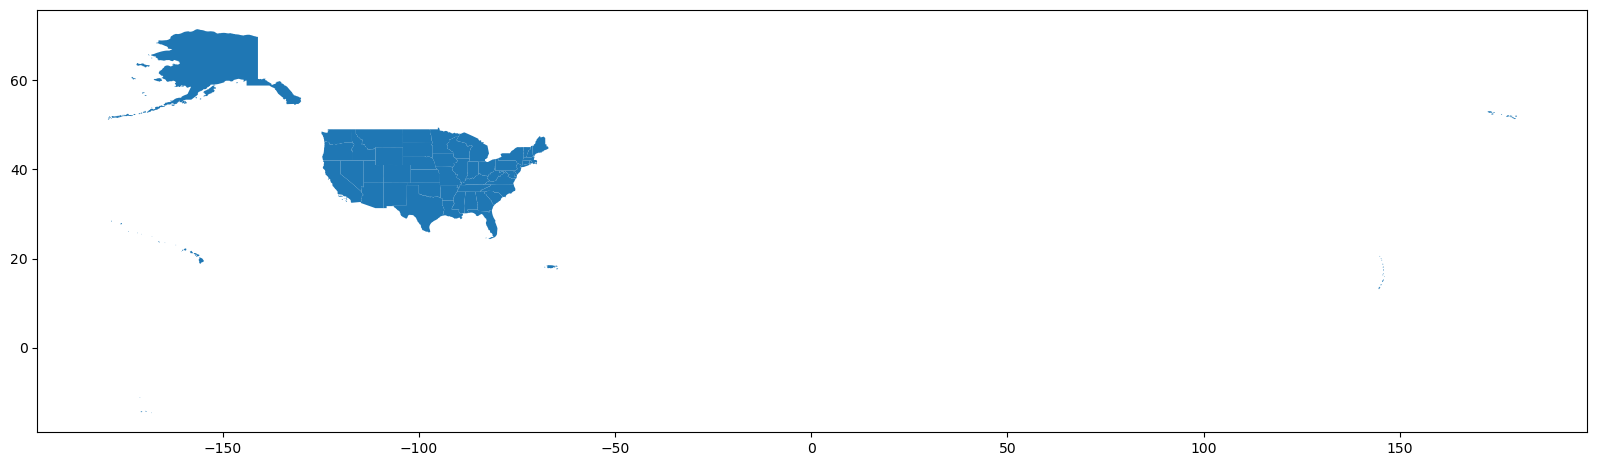

In [44]:
countries_gdf.plot(figsize=(20, 10))

In [45]:
countries_gdf = countries_gdf.to_crs("EPSG:4326")

In [46]:
geo_df = geo_df.sjoin(countries_gdf, how="left", predicate="intersects")

In [47]:
geo_df.NAME.unique()

array(['Minnesota', 'Illinois', 'Nebraska', 'Ohio', 'Wisconsin',
       'Georgia', 'Iowa', 'Indiana', 'Missouri', 'Kansas', 'Nevada',
       'Tennessee', 'Alabama', 'Mississippi', 'California', 'New York',
       'Florida', nan, 'Texas', 'Virginia', 'North Carolina', 'Louisiana',
       'Washington', 'District of Columbia', 'Maryland', 'Pennsylvania',
       'Kentucky', 'Connecticut', 'Massachusetts', 'Delaware',
       'New Jersey', 'Guam', 'Hawaii', 'Colorado', 'Rhode Island', 'Utah',
       'Oregon', 'Arizona', 'Michigan', 'Oklahoma', 'Arkansas',
       'West Virginia', 'South Carolina', 'New Mexico', 'North Dakota',
       'New Hampshire', 'Maine', 'South Dakota', 'Montana', 'Wyoming',
       'Idaho', 'Vermont', 'Puerto Rico', 'Alaska',
       'United States Virgin Islands'], dtype=object)

In [52]:
geo_df.drop("index_right", inplace=True, axis=1)

In [56]:
geo_df.columns = ["userid", "placeid", "datetime", "id", "lat", "lng", "categoryid", "name", "geometry", "state"]

In [57]:
geo_df

,userid,placeid,datetime,id,lat,lng,categoryid,name,geometry,state
0,1338,482954,2011-06-23T02:24:22Z,482954,44.934198,-93.177506,3,Nightlife,POINT (-93.17751 44.93420),Minnesota
1,116691,482954,2011-06-05T17:42:29Z,482954,44.934198,-93.177506,3,Nightlife,POINT (-93.17751 44.93420),Minnesota
2,59161,482954,2011-01-14T01:39:11Z,482954,44.934198,-93.177506,3,Nightlife,POINT (-93.17751 44.93420),Minnesota
3,59161,482954,2010-07-23T01:32:22Z,482954,44.934198,-93.177506,3,Nightlife,POINT (-93.17751 44.93420),Minnesota
4,149777,482954,2010-03-18T01:40:40Z,482954,44.934198,-93.177506,3,Nightlife,POINT (-93.17751 44.93420),Minnesota
...,...,...,...,...,...,...,...,...,...,...
1042815,80336,6464232,2011-06-06T14:18:47Z,6464232,50.823806,-0.161326,6,Travel,POINT (-0.16133 50.82381),NaN
1042816,80336,4593370,2011-06-05T12:16:11Z,4593370,53.745687,-0.347396,2,Food,POINT (-0.34740 53.74569),NaN
1042817,80336,6504146,2011-06-05T11:07:24Z,6504146,53.751760,-0.315397,5,Shopping,POINT (-0.31540 53.75176),NaN
1042818,80336,7445594,2011-05-31T12:03:43Z,7445594,51.509726,-0.086678,2,Food,POINT (-0.08668 51.50973),NaN


In [58]:
geo_df.to_csv(os.path.join(general_dir, "gowalla_geo_checkins.csv"), index=False)

In [62]:
for x in geo_df.state.unique():
    state =  geo_df[geo_df["state"]==x][["userid", "placeid", "datetime", "lat", "lng", "categoryid", "name", "geometry", "state"]]
    state.to_csv(os.path.join(checkins_with_category, "checkins_local_{x}.csv"), index=False)